# fit the hot and cold loads to calibrate the data
### after some experimentation, I decided the HI contamination in the cold prevented an accurate temperature calibration and just concentrated on flattening the baseline so we study line profiles more accurately
#### 12/6/21 jpw

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import csv
import scipy as sp
from scipy.ndimage import median_filter
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from datetime import datetime
import pandas as pd
from scipy.ndimage.filters import uniform_filter1d
%matplotlib inline

In [2]:
# function to read in all the files in a directory and calculate the average spectrum (counts at each frequency channel)
def avespec(directory):
    # get the list of all spectra (csv files) in directory
    files = glob.glob(directory + '/*.csv')
    # you can print out the result to make sure its doing the right thing
    #print(files)
    
    # read in the first file to initialize the sum
    nu0, C_sum = np.genfromtxt(files[0], delimiter=',', unpack=True)
    
    # loop through all the other files and sum the counts
    for f in files[1:]:
        nu1, C1 = np.genfromtxt(f, delimiter=',', unpack=True)
        if np.array_equal(nu0,nu1):
            C_sum += C1
        else:
            print('Error: frequency axes are different in avespec')
            return False, False
        
    # divide by the number of files to produce the average
    C_ave = C_sum / len(files)
    
    return nu0, C_ave

In [3]:
# go to directory with the calibration data
path = '/Users/jpw/G/21cm_telescope/data_team2/'
date = '2021_12_01'
os.chdir(path+date)
filelist = os.listdir()
print(filelist)

['long60', 'long54', 'long48', 'long36', 'long42', 'long30', 'long18', 'long24', 'long0', 'hotData', 'coldData', 'reduction_log.txt', 'calibration.csv', 'Icon\r']


Text(0, 0.5, 'Counts')

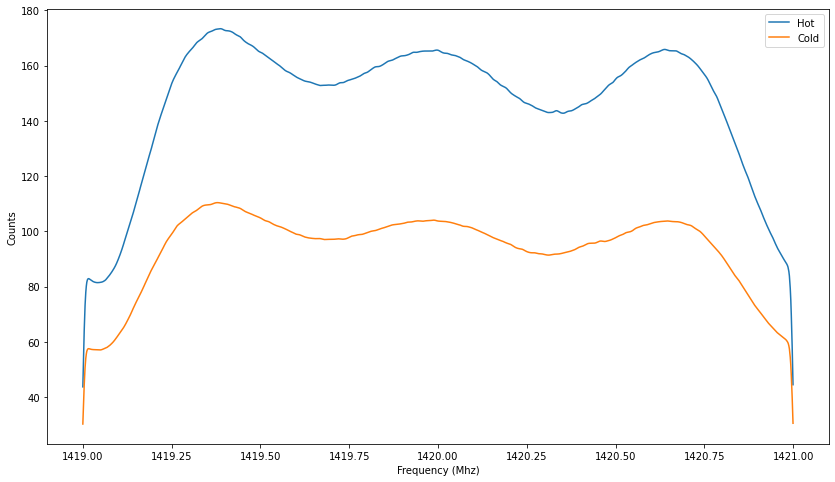

In [4]:
# average the spectra in each of the hot and cold directories
nu_hot, Chot = avespec('hotData')
nu_cold, Ccold = avespec('coldData/coldData90')
#nu_cold, Ccold = avespec('coldData/coldData64')
# note cold64 is junk - the HI line is strong and broad :(

if np.array_equal(nu_hot,nu_cold):
    nu = nu_hot
else:
    print('Error: Hot and Cold frequency axes are different')

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu, Chot, label='Hot')
ax.plot(nu, Ccold, label='Cold')
ax.legend()
ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Counts')

# note that the observing mode for hot and cold automatically despikes and smooths the data

Text(0, 0.5, 'Chot / Ccold')

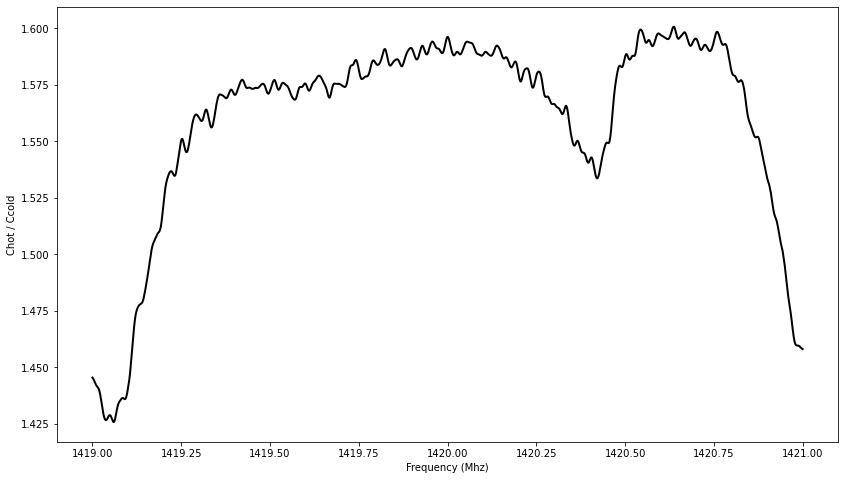

In [5]:
# look at the hot / cold ratio
# should be fairly constant

ratio = Chot / Ccold

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu, ratio, lw=2, color='black')
ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Chot / Ccold')

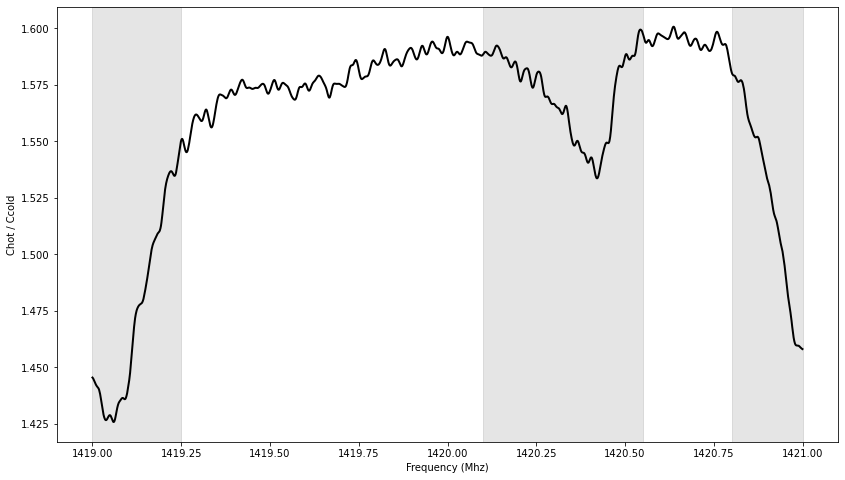

In [6]:
# mask out the edges of the bandpass where the sensitivity drops
# and the HI line in the cold load
# this is user-defined (i.e., subjective) for now...

nu_edge1 = [1419.00, 1419.25]
nu_edge2 = [1420.80, 1421.00]
nu_coldline = [1420.10, 1420.55]

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu, ratio, lw=2, color='black')
ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Chot / Ccold')

ax.axvspan(nu_edge1[0], nu_edge1[1], color='black', alpha=0.1)
ax.axvspan(nu_edge2[0], nu_edge2[1], color='black', alpha=0.1)
ax.axvspan(nu_coldline[0], nu_coldline[1], color='black', alpha=0.1)

Text(0, 0.5, 'Chot / Ccold')

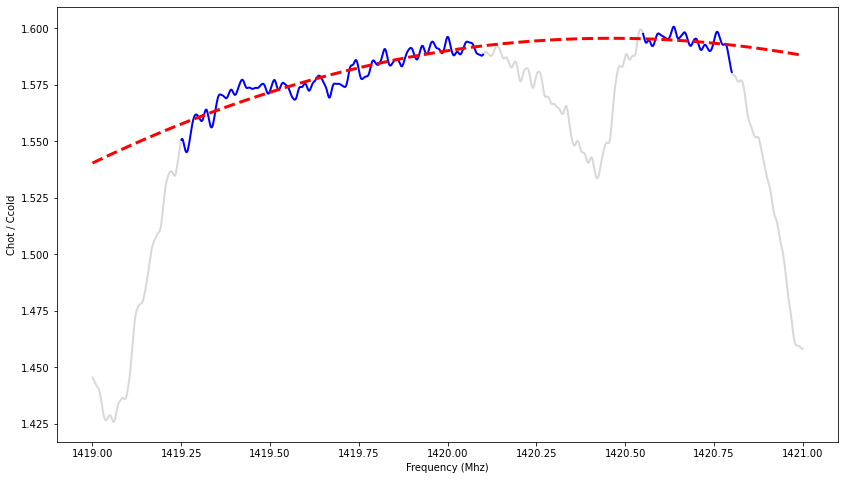

In [7]:
# fit the ratio away from the HI line with a quadratic function

bad1 = nu < nu_edge1[1]
bad2 = (nu > nu_coldline[0]) & (nu < nu_coldline[1])
bad3 = nu > nu_edge2[0]
bad = bad1 + bad2 + bad3

good1 = (nu > nu_edge1[1]) & (nu < nu_coldline[0])
good2 = (nu > nu_coldline[1]) & (nu < nu_edge2[0])
good = good1 + good2

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu[bad1], ratio[bad1], lw=2, color='gray', alpha=0.3)
ax.plot(nu[bad2], ratio[bad2], lw=2, color='gray', alpha=0.3)
ax.plot(nu[bad3], ratio[bad3], lw=2, color='gray', alpha=0.3)
ax.plot(nu[good1], ratio[good1], lw=2, color='blue')
ax.plot(nu[good2], ratio[good2], lw=2, color='blue')

order = 2
p = np.polyfit(nu[good], ratio[good], order)
ratio_fit = np.poly1d(p)
ax.plot(nu, ratio_fit(nu), color='red', linestyle='--', lw=3)

ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Chot / Ccold')

Text(0, 0.5, 'Counts')

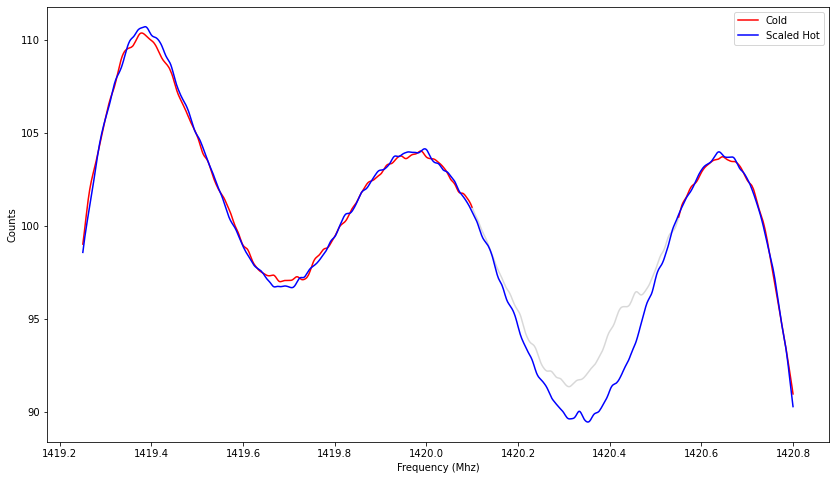

In [8]:
# check how well the fit works by scaling the hot load to the cold load

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu[good1], Ccold[good1], label='Cold', color='red')
ax.plot(nu[good2], Ccold[good2], color='red')
ax.plot(nu[bad2], Ccold[bad2], color='gray', alpha=0.3)

bpass1 = nu > nu_edge1[1]
bpass2 = nu < nu_edge2[0]
bpass = bpass1 & bpass2
ax.plot(nu[bpass], Chot[bpass] / ratio_fit(nu[bpass]), color='blue', label='Scaled Hot')

ax.legend()
ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Counts')

Text(0.1, 0.9, 'Cold64')

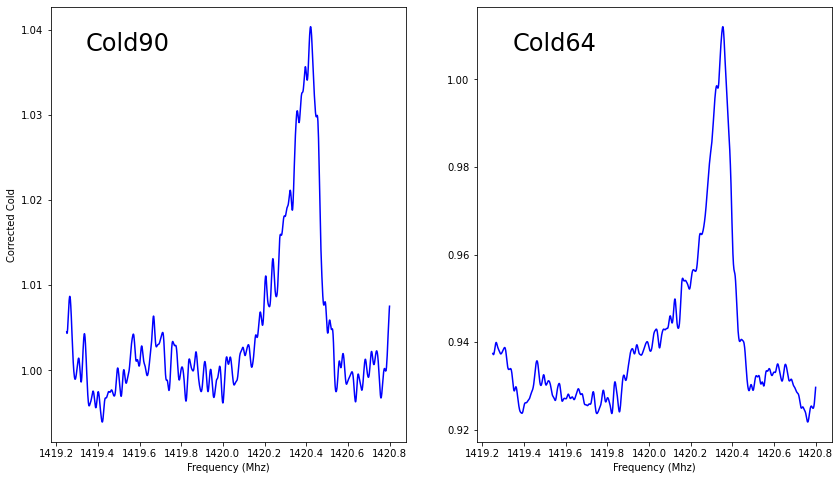

In [9]:
# look at the ratio to flatten the bandpass
# and compare with cold64 as a further test (works well - just a linear offset)
nu_cold, Ccold64 = avespec('coldData/coldData64')

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
ax1.plot(nu[bpass], Ccold[bpass] * ratio_fit(nu[bpass]) / Chot[bpass], color='blue', label='Cold90')
ax2 = fig.add_subplot(122)
ax2.plot(nu[bpass], Ccold64[bpass] * ratio_fit(nu[bpass]) / Chot[bpass], color='blue', label='Cold64')

ax1.set_xlabel('Frequency (Mhz)')
ax2.set_xlabel('Frequency (Mhz)')
ax1.set_ylabel('Corrected Cold')
ax1.text(0.1, 0.9, 'Cold90', fontsize=24, transform=ax1.transAxes)
ax2.text(0.1, 0.9, 'Cold64', fontsize=24, transform=ax2.transAxes)

Text(0.1, 0.9, 'Cold64')

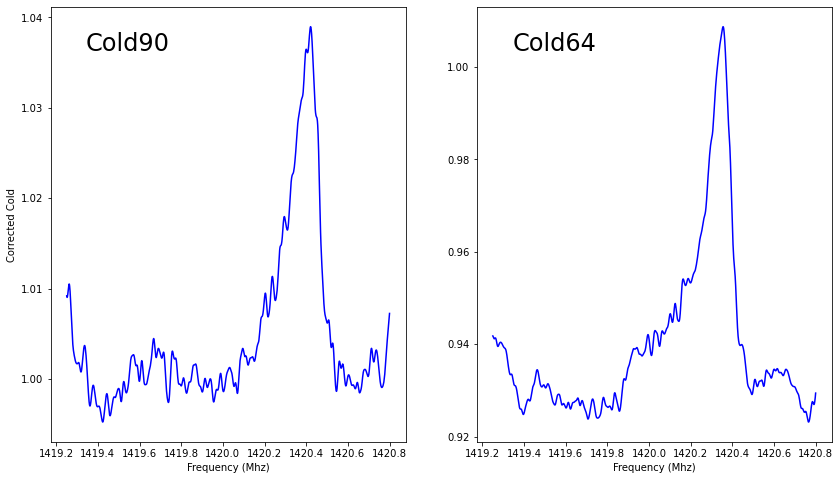

In [10]:
# smooth the hot load with a running mean to keep the bandpass shape but reduce the noise

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
ax1.plot(nu[bpass], Ccold[bpass] * ratio_fit(nu[bpass]) / uniform_filter1d(Chot,100)[bpass], color='blue', label='Cold90')
ax2 = fig.add_subplot(122)
ax2.plot(nu[bpass], Ccold64[bpass] * ratio_fit(nu[bpass]) / uniform_filter1d(Chot,100)[bpass], color='blue', label='Cold64')

ax1.set_xlabel('Frequency (Mhz)')
ax2.set_xlabel('Frequency (Mhz)')
ax1.set_ylabel('Corrected Cold')
ax1.text(0.1, 0.9, 'Cold90', fontsize=24, transform=ax1.transAxes)
ax2.text(0.1, 0.9, 'Cold64', fontsize=24, transform=ax2.transAxes)

Text(0, 0.5, 'Chot (Counts)')

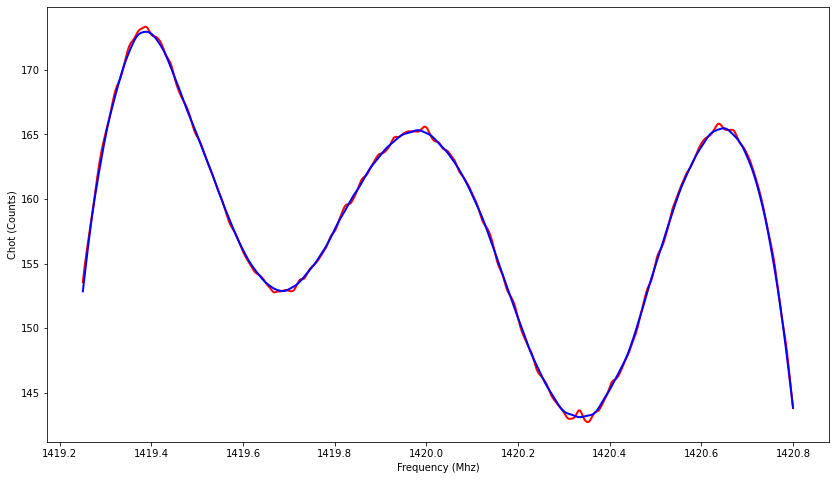

In [11]:
# play around with ways to make a amooth function for Chot
# binning the data would require interpolation
# uniform_filter1d does a running mean, choose the smoothing size to recover bandpass shape with minimal noise

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(111)
ax1.plot(nu[bpass], Chot[bpass], lw=2, color='r')

# bin data as the polyfit fails due to the noise
nbin = 50
i0 = 0
nu_bin = []
C_bin = []
w_bin = []
for i in range(i0+nbin,nu.size,nbin):
    nu_bin.append(np.mean(nu[i0:i]))
    C_bin.append(np.mean(Chot[i0:i]))
    w_bin.append(1/np.var(Chot[i0:i]))
    i0 = i
    #ax1.plot(nu_bin, C_bin, 'bo')

ax1.plot(nu[bpass], uniform_filter1d(Chot,100)[bpass], lw=2, color='blue', linestyle='-')

ax1.set_xlabel('Frequency (Mhz)')
ax1.set_ylabel('Chot (Counts)')


In [12]:
# if you are happy with the flattening of the bandpass, write it out for use in the the data reduction script

fname = 'calibration.csv'
if os.path.exists(fname):
    print('*** Calibration file already exists: ', fname)
    print('*** Delete this manually if you want to overwrite')
else:
    # zip the two arrays together so they write out as rows and reverse the order so v goes from low to high
    print('Writing calibration spectrum to ', fname)
    with open(fname, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(zip(nu, ratio_fit(nu) / uniform_filter1d(Chot,100)))

*** Calibration file already exists:  calibration.csv
*** Delete this manually if you want to overwrite
